In [336]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt

os.chdir("/Users/jacobrichards/Desktop/DS_DA_Projects/3-90+_DaysPastDue/data")

train = pd.read_csv("train.csv", na_values=["", "NA"])

test = pd.read_csv("test.csv", na_values=["", "NA"])

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Process data

Remove upper and lower 1% of feature 3 for train but not test.

In [337]:
lower_bound = train['feature_3'].quantile(0.01)
upper_bound = train['feature_3'].quantile(0.99)

train = train[(train['feature_3'] >= lower_bound) & (train['feature_3'] <= upper_bound)]

Replace na with median value for both.

In [338]:
train_median = train['feature_3'].median()
train['feature_3'].fillna(train_median, inplace=True)

test_median = test['feature_3'].median()
test['feature_3'].fillna(test_median, inplace=True)

Replace na of feature 2 with forward fill and backward fill.

In [339]:
train['date'] = pd.to_datetime(train['date']).dt.year
test['date'] = pd.to_datetime(test['date']).dt.year

def impute_feature_2(df):
    df = df.sort_values(by=['id', 'date'])
    df['feature_2'] = df['feature_2'].fillna(method='ffill')
    df['feature_2'] = df['feature_2'].fillna(method='bfill')
    return df

train = train.groupby('id', group_keys=False).apply(impute_feature_2)
test = test.groupby('id', group_keys=False).apply(impute_feature_2)

Replace y with 1 if 90+DPD and 0 if active.

In [340]:
train['y'] = train['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)
test['y'] = test['y'].apply(lambda x: 1 if x == "90+DPD" else 0 if x == "active" else x)

Standardize features.

In [341]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.fit_transform(train[['feature_1', 'feature_2', 'feature_3', 'feature_4']])
test[['feature_1', 'feature_2', 'feature_3', 'feature_4']] = scaler.transform(test[['feature_1', 'feature_2', 'feature_3', 'feature_4']])

In [342]:
print(train.head(15))

    feature_1  feature_2  feature_3  feature_4     id  date  y
0    0.053493   0.057374  -0.073933  -0.420557  50501  2000  0
1   -0.315388   0.029476  -0.140006   0.997907  50501  2001  1
2   -0.225211  -1.153009  -0.069998   1.362336  50501  2002  0
3   -0.209159  -0.067340  -0.153642   0.145434  50501  2003  0
4   -0.174308  -1.690908  -0.005939   1.902415  50501  2004  0
5   -0.078704  -0.690428  -0.003381   1.352704  50501  2005  0
6    0.194896  -0.690428   0.036845   0.205534  50501  2006  0
7   -0.103617   0.823487  -0.141389  -0.336979  50501  2007  0
8    5.891015   1.659224   0.238704  -2.084758  50501  2008  0
9   -0.024418   0.141166  -0.070976   0.109444  50501  2009  0
11  -0.005445  -0.829163   0.063643   1.798816  50501  2011  0
12   0.509061   1.014947   0.188967   0.297211  50501  2012  0
13   0.198807   0.885452   0.046984   0.318295  50501  2013  0
15   0.504127   1.053210   0.071757  -1.258705  50502  2000  0
16  -0.584827   0.386654  -0.300616   0.518147  50502  

# Logistic Regression Model 

Produce all possible interaction terms.

In [343]:
train['feature_1_x_feature_2'] = train['feature_1'] * train['feature_2']
test['feature_1_x_feature_2'] = test['feature_1'] * test['feature_2']

train['feature_1_x_feature_3'] = train['feature_1'] * train['feature_3']
test['feature_1_x_feature_3'] = test['feature_1'] * test['feature_3']

train['feature_1_x_feature_4'] = train['feature_1'] * train['feature_4']
test['feature_1_x_feature_4'] = test['feature_1'] * test['feature_4']

train['feature_2_x_feature_3'] = train['feature_2'] * train['feature_3']
test['feature_2_x_feature_3'] = test['feature_2'] * test['feature_3']

train['feature_2_x_feature_4'] = train['feature_2'] * train['feature_4']
test['feature_2_x_feature_4'] = test['feature_2'] * test['feature_4']

train['feature_3_x_feature_4'] = train['feature_3'] * train['feature_4']
test['feature_3_x_feature_4'] = test['feature_3'] * test['feature_4']

Evaluate model on training data with every possible combination of interaction terms and select combination with best AUC score from ROC curve.

In [344]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import numpy as np
from itertools import combinations

base_features = ['feature_1', 'feature_2', 'feature_3', 'feature_4']
interaction_terms = ['feature_1_x_feature_2', 'feature_1_x_feature_3',
                     'feature_1_x_feature_4', 'feature_2_x_feature_3', 
                     'feature_2_x_feature_4', 'feature_3_x_feature_4']

y_train = train['y']
results = []
for r in range(len(interaction_terms) + 1):
    for interaction_combo in combinations(interaction_terms, r):
        features = base_features + list(interaction_combo)
        X_train_subset = train[features]
        
        model = LogisticRegression(fit_intercept=True)
        model.fit(X_train_subset, y_train)
        
        y_pred_proba = model.predict_proba(X_train_subset)[:,1]
        fpr, tpr, _ = roc_curve(y_train, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        results.append({
            'interaction_terms': interaction_combo,
            'auc': roc_auc,
            'features': features
        })

results.sort(key=lambda x: x['auc'], reverse=True)

print("Models ranked by AUC score (training data):")
for i, result in enumerate(results, 1):
    print(f"\n{i}. AUC: {result['auc']:.4f}")
    print("Interaction terms used:", 
          "None" if not result['interaction_terms'] else list(result['interaction_terms']))

Models ranked by AUC score (training data):

1. AUC: 0.9674
Interaction terms used: ['feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']

2. AUC: 0.9674
Interaction terms used: ['feature_1_x_feature_2', 'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']

3. AUC: 0.9672
Interaction terms used: ['feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_2_x_feature_4']

4. AUC: 0.9671
Interaction terms used: ['feature_1_x_feature_2', 'feature_2_x_feature_4', 'feature_3_x_feature_4']

5. AUC: 0.9671
Interaction terms used: ['feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']

6. AUC: 0.9670
Interaction terms used: ['feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_2_x_feature_4']

7. AUC: 0.9669
Interaction terms used: ['feature_1_x_feature_2', 'feature_2_x_feature_3', 'feature_2_x_feature_4']

8. AUC: 0.9667
Int

Evaluate model on testing data with best possible combination of interaction terms found from model evaluation on training data.

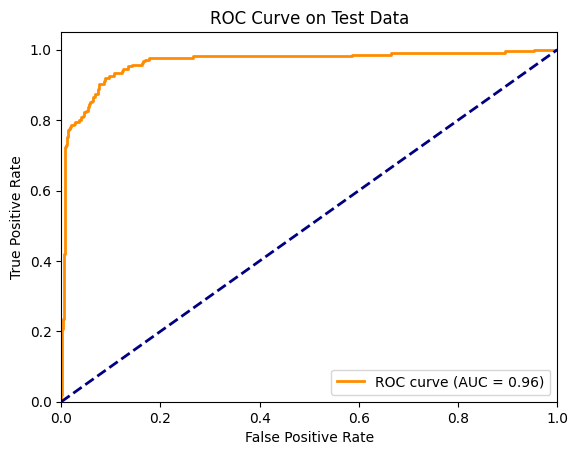

In [345]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
X_train = train[['feature_1', 'feature_2', 'feature_3', 'feature_4',
                 'feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']]
y_train = train['y']

model = LogisticRegression(fit_intercept=True)
model.fit(X_train, y_train);



X_test = test[['feature_1', 'feature_2', 'feature_3', 'feature_4',
               'feature_1_x_feature_2', 'feature_1_x_feature_3', 'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']]

y_test = test['y']
y_pred_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve on Test Data')
plt.legend(loc="lower right")
plt.show()

Optimal threshold.

In [346]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")

Optimal threshold: 0.307


Recall at optimal decision threshold. 

In [347]:
from sklearn.metrics import confusion_matrix, recall_score

y_pred = (y_pred_proba >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nRecall at optimal threshold: {recall:.3f}")

Confusion Matrix:
[[771  74]
 [ 19 195]]

Recall at optimal threshold: 0.911


# Modeled Probabilities and Log(ods) against observed probabilities by predictors.

Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8


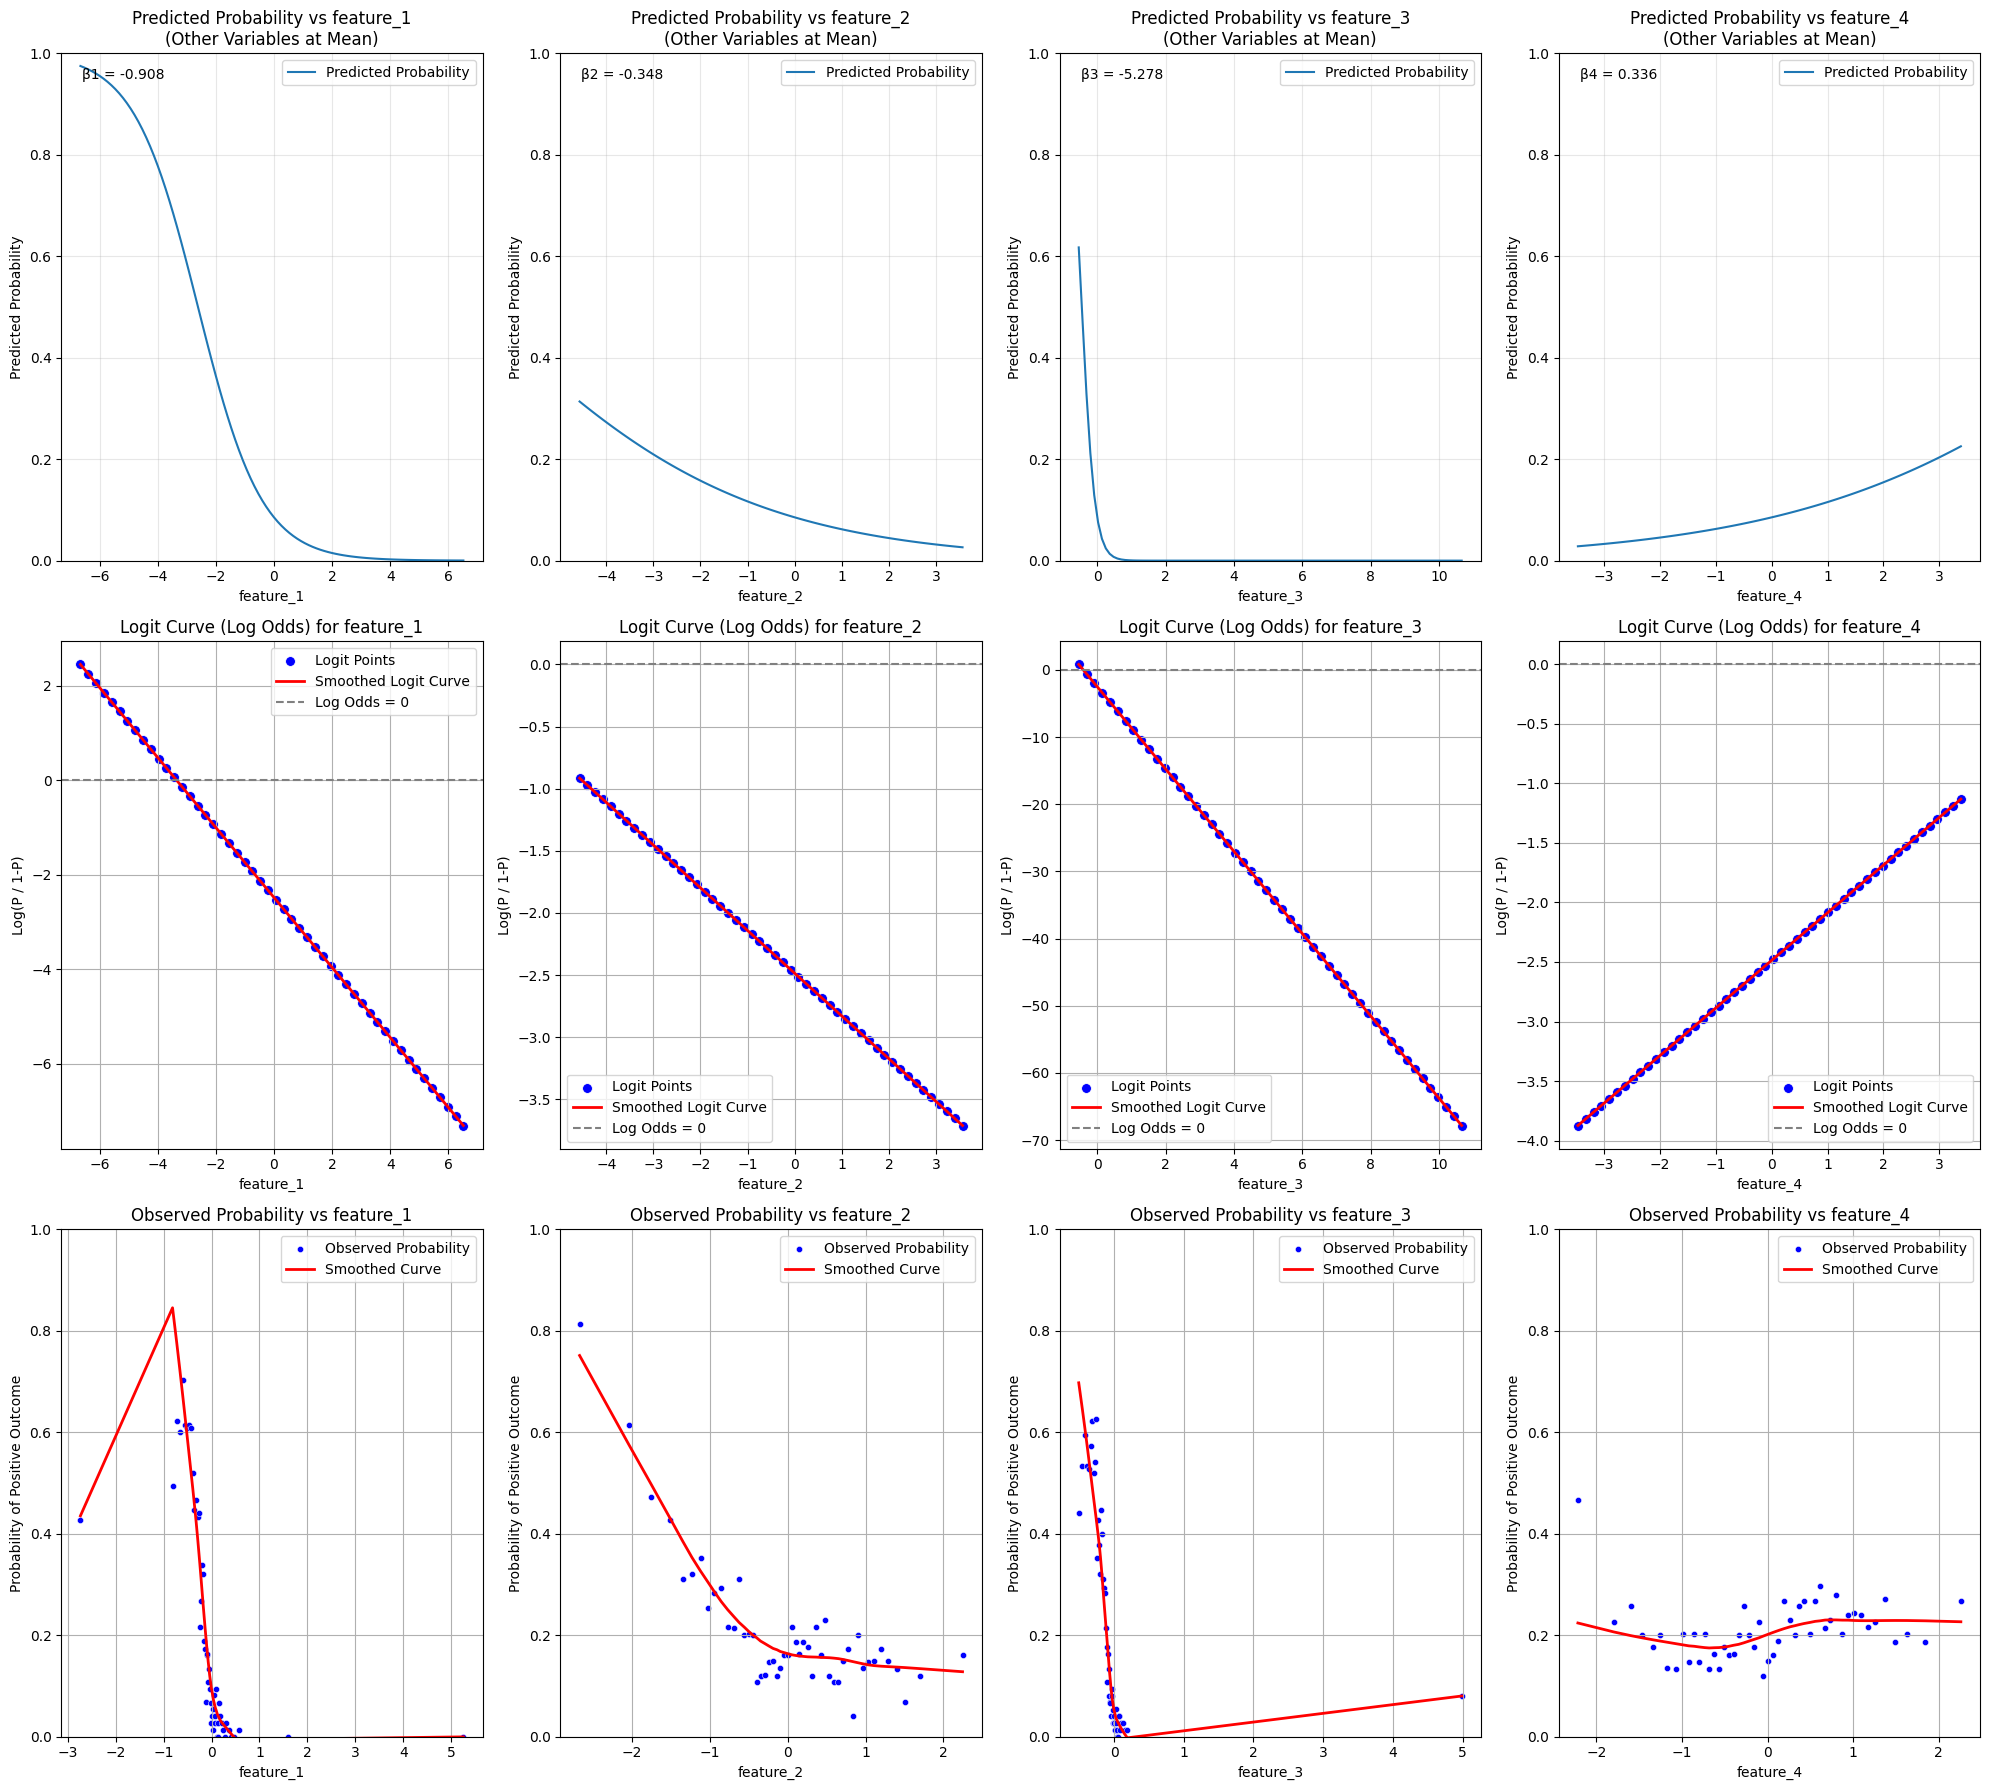

In [348]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y = train['y']

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X, y)

fig1, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12)) = plt.subplots(3, 4, figsize=(20, 18))

mean_values = X.mean()
coefficients = lr_model.coef_[0]

for i, feature in enumerate(['feature_1', 'feature_2', 'feature_3', 'feature_4']):
    x_range = np.linspace(X[feature].min(), X[feature].max(), 100)
    
    pred_data = np.tile(mean_values, (100, 1))
    pred_data = pd.DataFrame(pred_data, columns=X.columns)
    pred_data[feature] = x_range
    
    y_pred = lr_model.predict_proba(pred_data)[:, 1]
    
    axes_top = [ax1, ax2, ax3, ax4]
    axes_top[i].plot(x_range, y_pred, label='Predicted Probability')
    axes_top[i].text(0.05, 0.95, f'β{i+1} = {coefficients[i]:.3f}', transform=axes_top[i].transAxes)
    axes_top[i].set_title(f'Predicted Probability vs {feature}\n(Other Variables at Mean)')
    axes_top[i].set_ylabel('Predicted Probability')
    axes_top[i].set_xlabel(feature)
    axes_top[i].grid(True, alpha=0.3)
    axes_top[i].set_ylim(0, 1)
    axes_top[i].legend()
    
    X_with_const = sm.add_constant(X)
    logit_model = sm.Logit(y, X_with_const)
    result = logit_model.fit()
    
    feature_values = np.linspace(X[feature].min(), X[feature].max(), 50)
    fixed_predictors = mean_values.copy()
    log_odds = []
    
    for value in feature_values:
        temp_predictors = fixed_predictors.copy()
        temp_predictors[feature] = value
        predictors_with_const = sm.add_constant(temp_predictors.values.reshape(1, -1), has_constant='add')
        logit = np.dot(predictors_with_const, result.params)
        log_odds.append(logit[0])
    
    plot_df = pd.DataFrame({
        feature: feature_values,
        'log_odds': log_odds
    })
    
    axes_middle = [ax5, ax6, ax7, ax8]
    sns.scatterplot(x=feature, y='log_odds', data=plot_df, color='blue', s=50, 
                    ax=axes_middle[i], label='Logit Points')
    sns.regplot(x=feature, y='log_odds', data=plot_df, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes_middle[i], label='Smoothed Logit Curve')
    
    axes_middle[i].set_title(f'Logit Curve (Log Odds) for {feature}')
    axes_middle[i].set_xlabel(feature)
    axes_middle[i].set_ylabel('Log(P / 1-P)')
    axes_middle[i].axhline(0, color='grey', linestyle='--', label='Log Odds = 0')
    axes_middle[i].legend()
    axes_middle[i].grid(True)
    
    bins = pd.qcut(X[feature], q=50, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    axes_bottom = [ax9, ax10, ax11, ax12]
    sns.scatterplot(x=bin_means, y=bin_probs, ax=axes_bottom[i], color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes_bottom[i], label='Smoothed Curve')
    
    axes_bottom[i].set_title(f'Observed Probability vs {feature}')
    axes_bottom[i].set_xlabel(feature)
    axes_bottom[i].set_ylabel('Probability of Positive Outcome')
    axes_bottom[i].set_ylim(0, 1)
    axes_bottom[i].legend()
    axes_bottom[i].grid(True)

plt.tight_layout()
plt.show()

It appears the reason that feature 1 has such a weaker negative term coefficient is because it has some left tail outliers which weaken it's over all trend.
I evaluated the model without feature 1's bottom tail and it made no difference on model performance. 

Verifying the strength of our Interaction terms as they've produced significant term coefficients. 

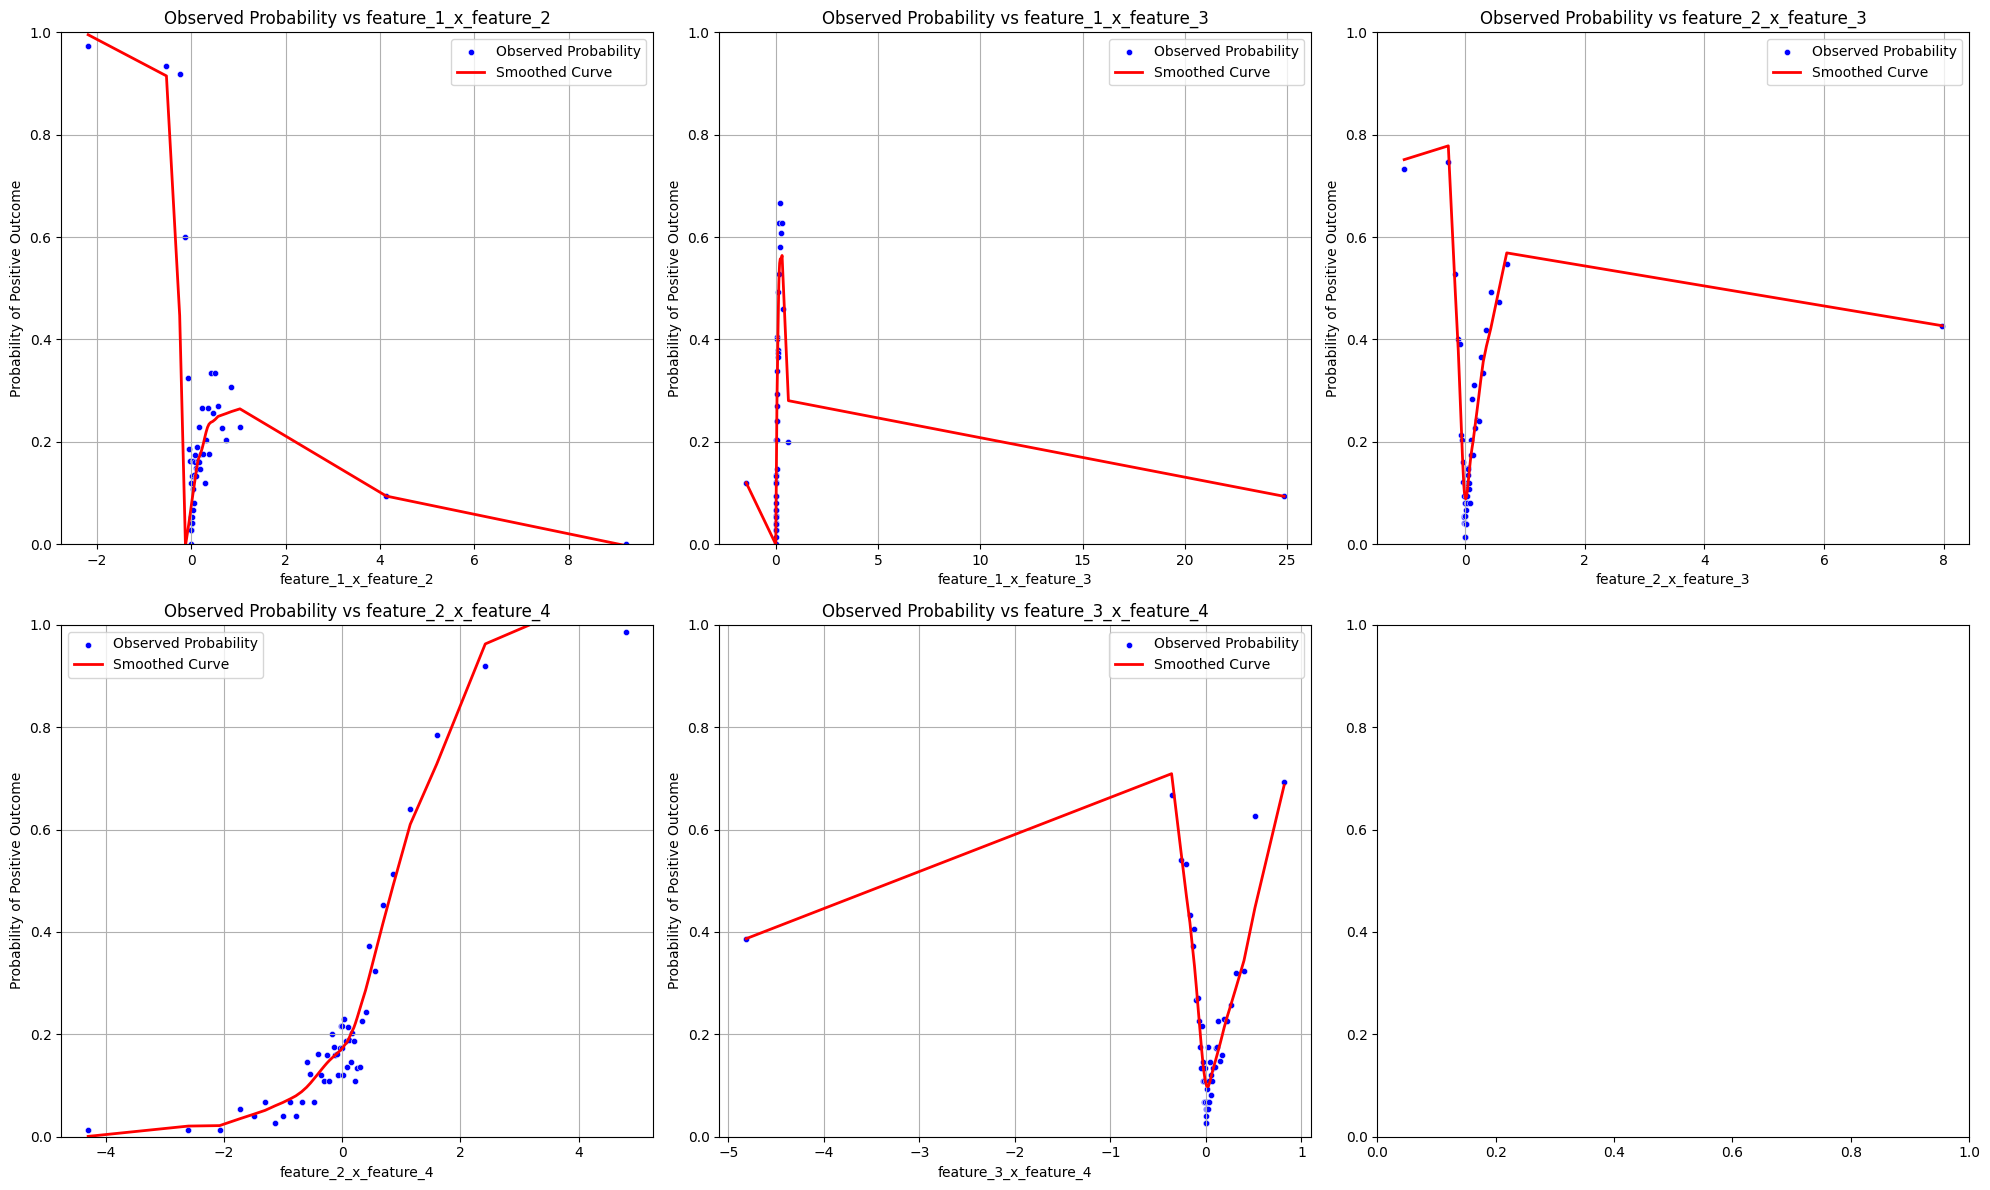

In [349]:
X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4',
           'feature_1_x_feature_2', 'feature_1_x_feature_3', 
           'feature_2_x_feature_3', 'feature_2_x_feature_4',
           'feature_3_x_feature_4']]
y = train['y']

fig1, ((ax1, ax2, ax3), (ax4, ax5, _)) = plt.subplots(2, 3, figsize=(20, 12))
axes = [ax1, ax2, ax3, ax4, ax5]

interaction_terms = ['feature_1_x_feature_2', 'feature_1_x_feature_3', 
                    'feature_2_x_feature_3', 'feature_2_x_feature_4', 
                    'feature_3_x_feature_4']

for i, feature in enumerate(interaction_terms):
    bins = pd.qcut(X[feature], q=50, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    sns.scatterplot(x=bin_means, y=bin_probs, ax=axes[i], color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[i], label='Smoothed Curve')
    
    axes[i].set_title(f'Observed Probability vs {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Probability of Positive Outcome')
    axes[i].set_ylim(0, 1)
    axes[i].legend()
    axes[i].grid(True)

plt.tight_layout()
plt.show()


# Strongest Predictors Visualized 

## Features 1 and 3 

Distributions of features 1 and 3 stratified by posative and negative outcomes. 

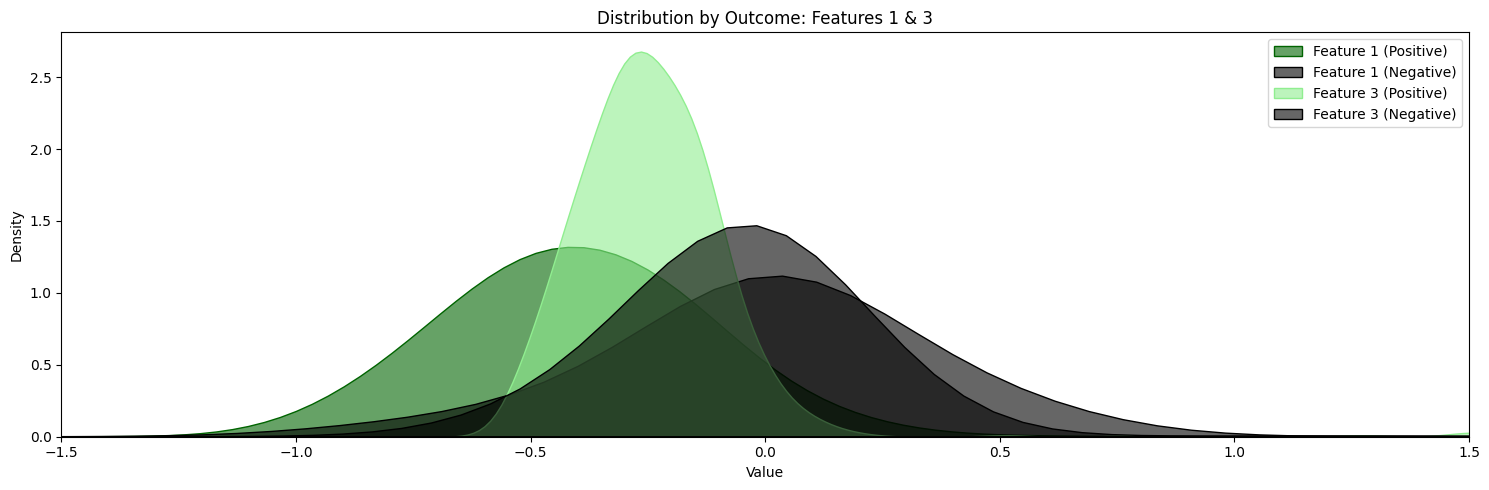

In [350]:
fig, ax = plt.subplots(figsize=(15, 5))

positive_data = train[train['y'] == 1]
negative_data = train[train['y'] == 0]

sns.kdeplot(data=positive_data['feature_1'], ax=ax, fill=True, alpha=0.6, label='Feature 1 (Positive)', color='darkgreen')
sns.kdeplot(data=negative_data['feature_1'], ax=ax, fill=True, alpha=0.6, label='Feature 1 (Negative)', color='black')
sns.kdeplot(data=positive_data['feature_3'], ax=ax, fill=True, alpha=0.6, label='Feature 3 (Positive)', color='lightgreen')
sns.kdeplot(data=negative_data['feature_3'], ax=ax, fill=True, alpha=0.6, label='Feature 3 (Negative)', color='black')
ax.set_title('Distribution by Outcome: Features 1 & 3')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_xlim(-1.5, 1.5)
ax.legend()

plt.tight_layout()
plt.show()


Significantly different means of the positive negative outcomes for features 1 and 3. 

## Features 2 and 4 

Scatter plot of these 2 variables stratified by outcome. 

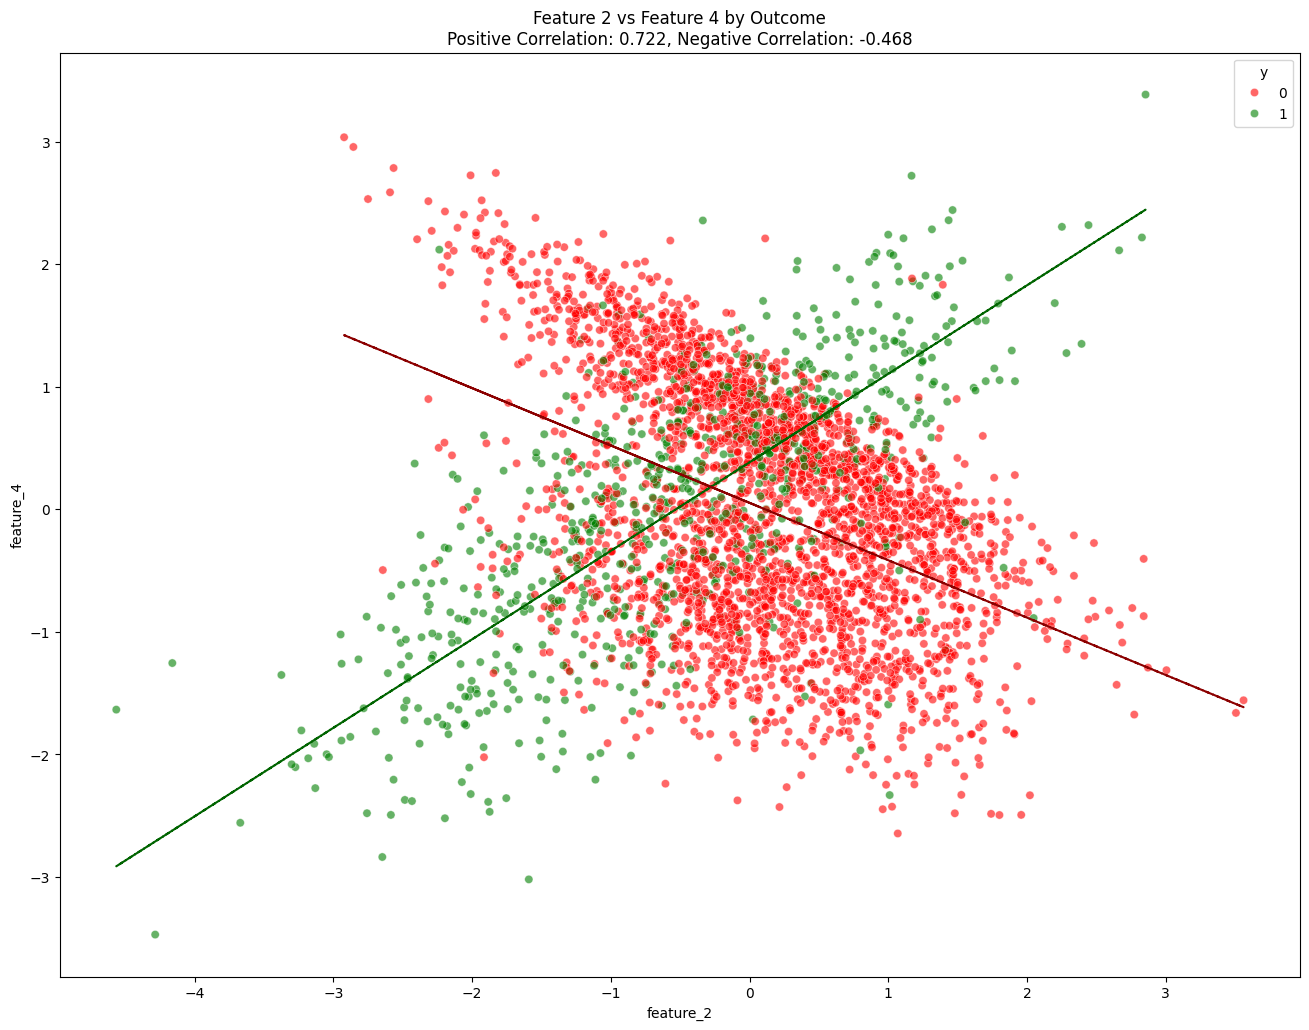

In [351]:
plt.figure(figsize=(16,12))

positive_data = train[train['y'] == 1]
negative_data = train[train['y'] == 0]

pos_corr = positive_data['feature_2'].corr(positive_data['feature_4'])
neg_corr = negative_data['feature_2'].corr(negative_data['feature_4'])

sns.scatterplot(data=train, x='feature_2', y='feature_4', hue='y',
                palette={1: 'green', 0: 'red'}, alpha=0.6)

x_pos = positive_data['feature_2']
y_pos = pos_corr * x_pos + (positive_data['feature_4'].mean() - pos_corr * positive_data['feature_2'].mean())
plt.plot(x_pos, y_pos, color='darkgreen', linestyle='--')

x_neg = negative_data['feature_2']
y_neg = neg_corr * x_neg + (negative_data['feature_4'].mean() - neg_corr * negative_data['feature_2'].mean())
plt.plot(x_neg, y_neg, color='darkred', linestyle='--')

plt.title(f'Feature 2 vs Feature 4 by Outcome\nPositive Correlation: {pos_corr:.3f}, Negative Correlation: {neg_corr:.3f}')
plt.show()

Probabilities produced by model of feature 2x4 interaction term in comparison to observed probabilities within data set. 

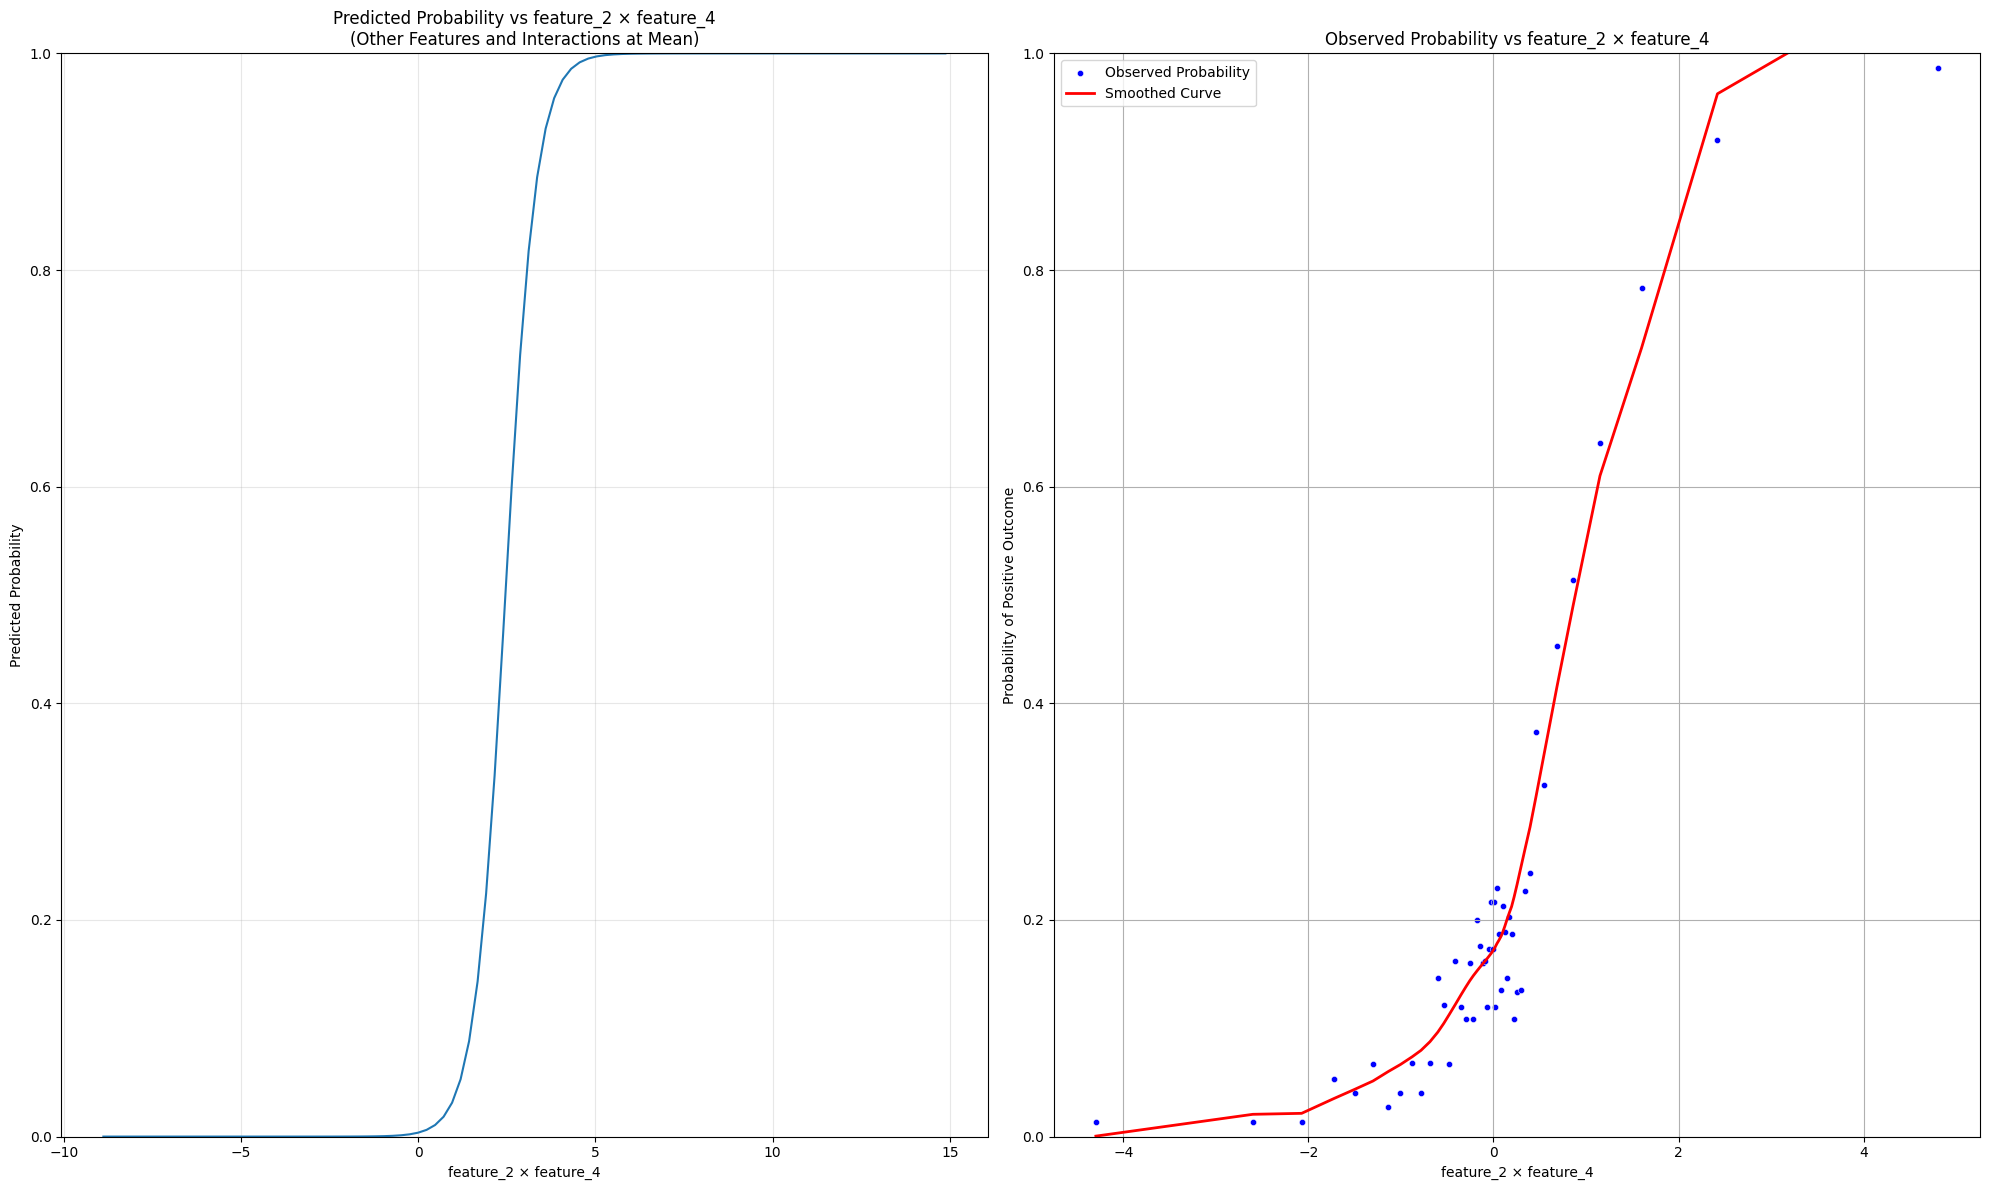

In [352]:
X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4', 
           'feature_1_x_feature_2', 'feature_1_x_feature_3',
           'feature_2_x_feature_3', 'feature_2_x_feature_4', 'feature_3_x_feature_4']]
y = train['y']

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X, y)

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12))

mean_values = X.mean()
interaction_range = np.linspace(train['feature_2_x_feature_4'].min(), train['feature_2_x_feature_4'].max(), 100)

pred_data = np.tile(mean_values, (100, 1))
pred_data = pd.DataFrame(pred_data, columns=X.columns)
pred_data['feature_2_x_feature_4'] = interaction_range

y_pred = lr_model.predict_proba(pred_data)[:, 1]

ax1.plot(interaction_range, y_pred)
ax1.set_title('Predicted Probability vs feature_2 × feature_4\n(Other Features and Interactions at Mean)')
ax1.set_ylabel('Predicted Probability')
ax1.set_xlabel('feature_2 × feature_4')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

bins = pd.qcut(X['feature_2_x_feature_4'], q=50, duplicates='drop')
bin_means = X.groupby(bins)['feature_2_x_feature_4'].mean()
bin_probs = train.groupby(bins)['y'].mean()

sns.scatterplot(x=bin_means, y=bin_probs, ax=ax2, color='blue', s=20, label='Observed Probability')
sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
            color='red', line_kws={'lw': 2}, ax=ax2, label='Smoothed Curve')

ax2.set_title('Observed Probability vs feature_2 × feature_4')
ax2.set_xlabel('feature_2 × feature_4')
ax2.set_ylabel('Probability of Positive Outcome')
ax2.set_ylim(0, 1)
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()


Thus the interaction term produced for features 2 and 4 had a highly predictive coefficient.

Interactions plot. 

Optimization terminated successfully.
         Current function value: 0.365151
         Iterations 8


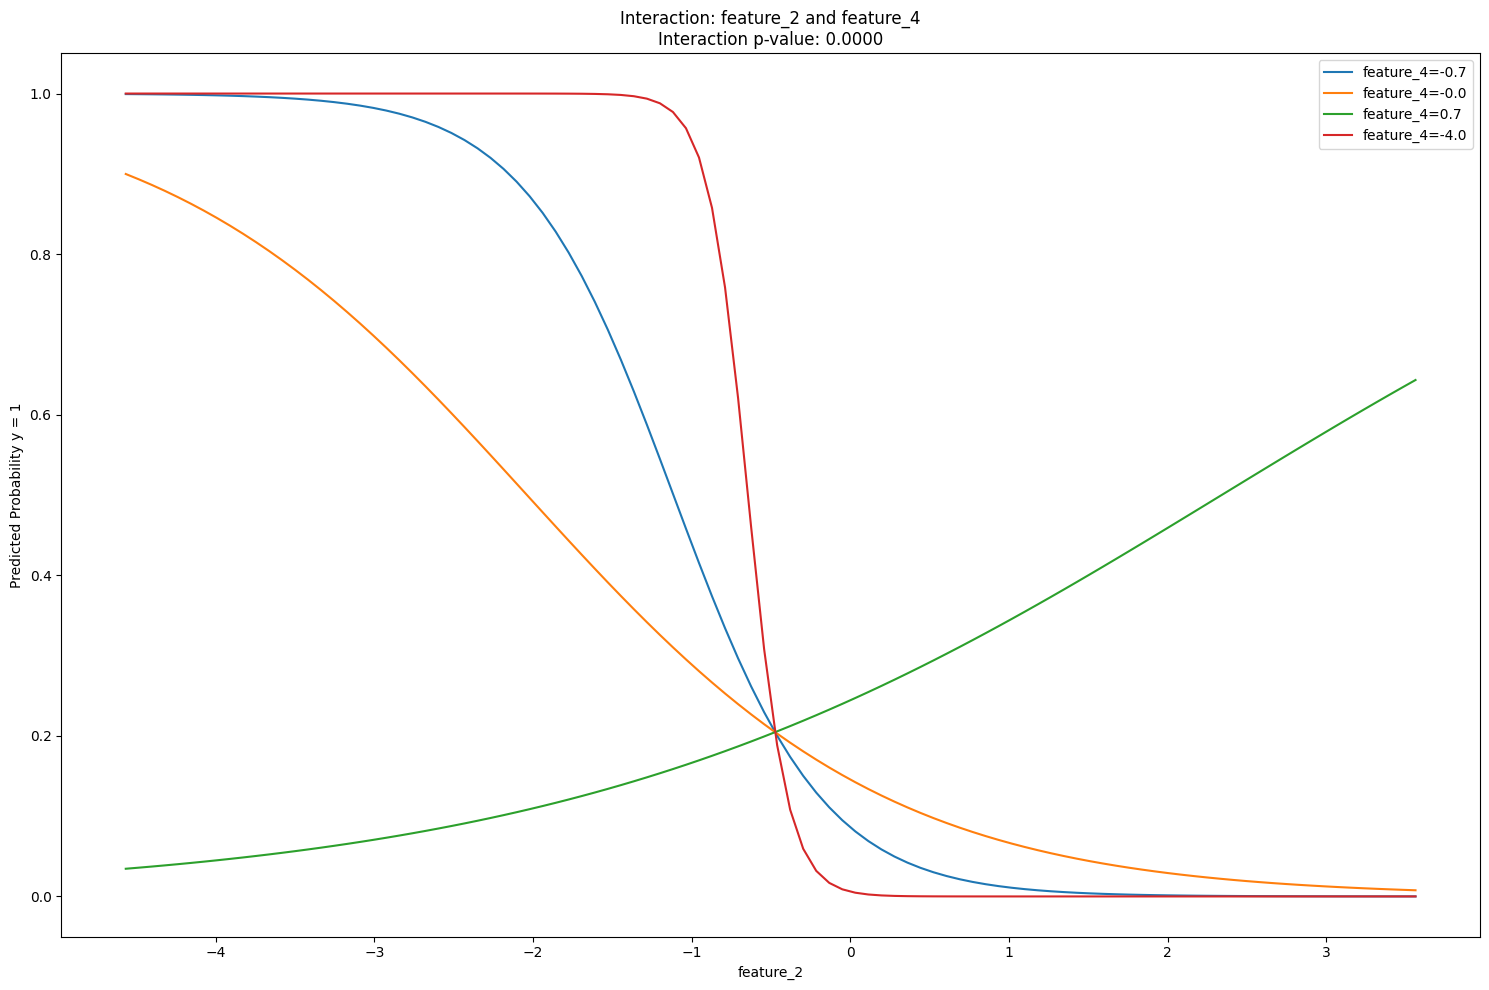


Significant interaction (p < 0.05):
feature_2 x feature_4


In [353]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 10))

formula = 'y ~ feature_2 * feature_4'
model = sm.Logit.from_formula(formula, data=train).fit()
interaction_pvalue = model.pvalues['feature_2:feature_4']

feature_2_values = np.linspace(train['feature_2'].min(), train['feature_2'].max(), 100)
feature_4_levels = list(np.percentile(train['feature_4'], [25, 50, 75])) + [-4]

for feature_4_level in feature_4_levels:
    df = pd.DataFrame({
        'feature_2': feature_2_values,
        'feature_4': feature_4_level
    })
    df['interaction'] = df['feature_2'] * df['feature_4']
    df['predicted_prob'] = model.predict(sm.add_constant(df))
    
    ax.plot(df['feature_2'], df['predicted_prob'], 
           label=f'feature_4={feature_4_level:.1f}')

ax.set_xlabel('feature_2')
ax.set_ylabel('Predicted Probability y = 1')
ax.legend()
ax.set_title(f'Interaction: feature_2 and feature_4\nInteraction p-value: {interaction_pvalue:.4f}')

plt.tight_layout()
plt.show()

if interaction_pvalue < 0.05:
    print("\nSignificant interaction (p < 0.05):")
    print("feature_2 x feature_4")

# Random Forest Model

Optimal threshold: 0.230
Confusion Matrix:
[[796  49]
 [ 13 201]]

Recall at optimal threshold: 0.939


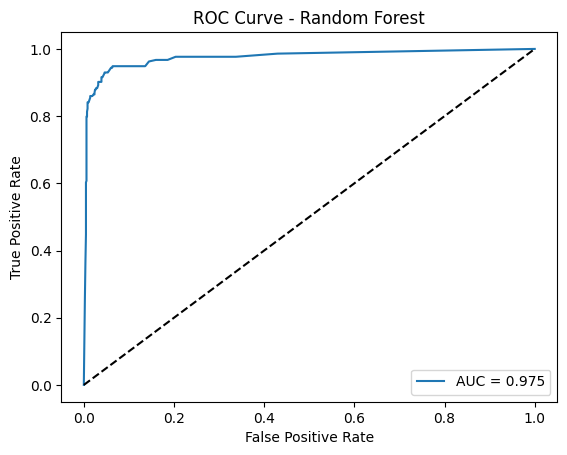

In [354]:
from sklearn.ensemble import RandomForestClassifier

X_train = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y_train = train['y']
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

X_test = test[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y_test = test['y']

rf_pred_proba = rf_model.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, rf_pred_proba)
auc_score = roc_auc_score(y_test, rf_pred_proba)

plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend()

fpr, tpr, thresholds = roc_curve(y_test, rf_pred_proba)
fnr = 1 - tpr
optimal_idx = np.argmin(np.abs(fpr - fnr))
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")

y_pred = (rf_pred_proba >= optimal_threshold).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print(f"\nRecall at optimal threshold: {recall:.3f}")

The RF model is moderately yet significantly better performing than our extensively fitted Logistic Regression model. 

# Check for Multi-collinearity

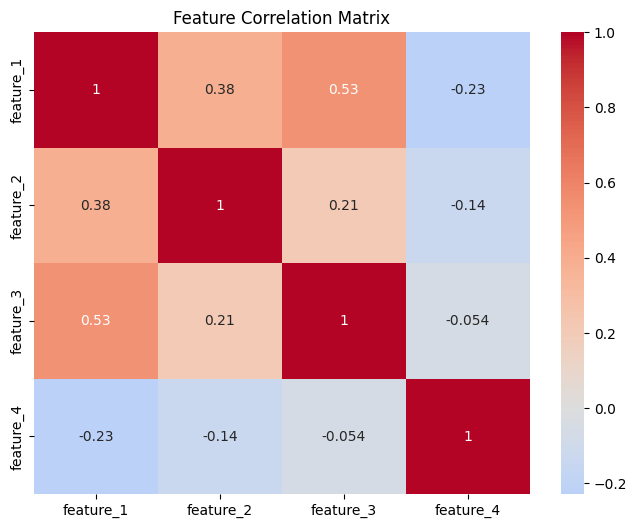

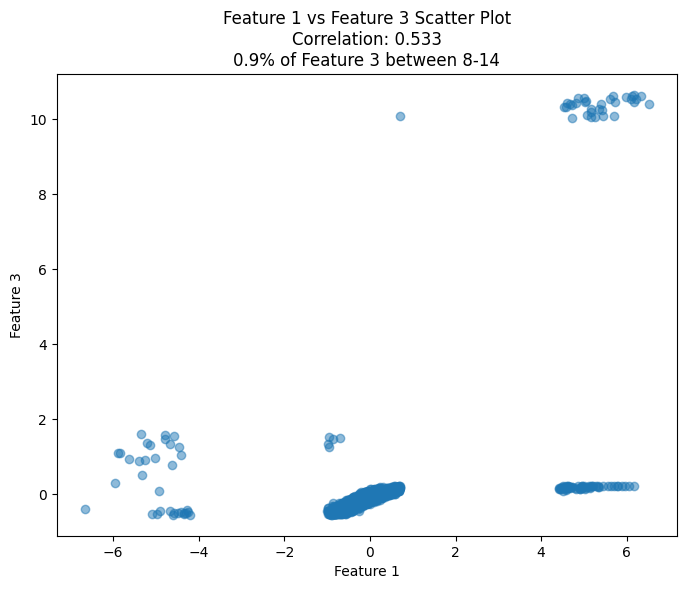

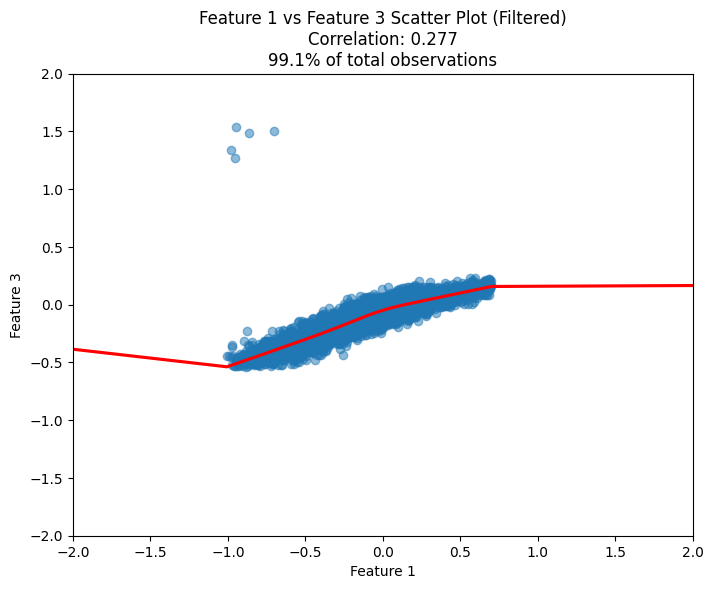

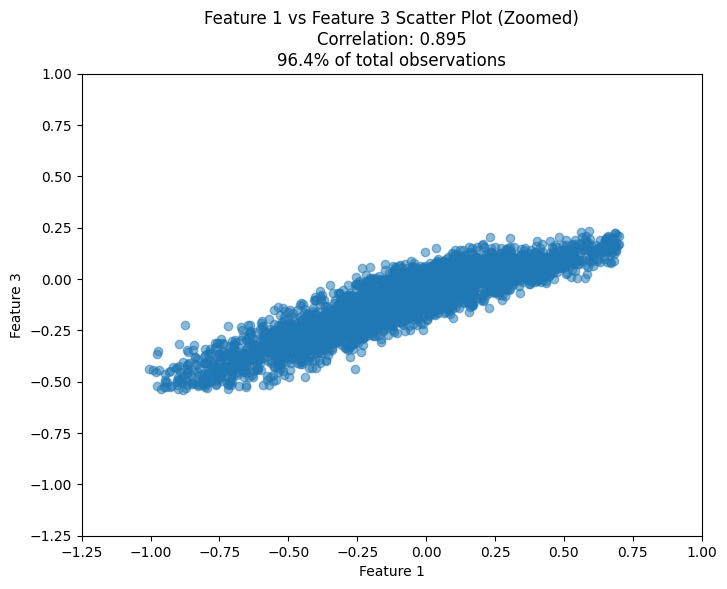

In [355]:
# Feature Correlation Matrix
correlation_matrix = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()


plt.figure(figsize=(8, 6))
plt.scatter(train['feature_1'], train['feature_3'], alpha=0.5)
corr = train['feature_1'].corr(train['feature_3'])
pct_between = (train['feature_3'][(train['feature_3'] >= 8) & (train['feature_3'] <= 14)].count() / train['feature_3'].count()) * 100
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title(f'Feature 1 vs Feature 3 Scatter Plot\nCorrelation: {corr:.3f}\n{pct_between:.1f}% of Feature 3 between 8-14')
plt.show()

filtered_data = train[~((train['feature_3'] >= 8) & (train['feature_3'] <= 14))]
pct_remaining = (len(filtered_data) / len(train)) * 100
plt.figure(figsize=(8, 6))
plt.scatter(filtered_data['feature_1'], filtered_data['feature_3'], alpha=0.5)
sns.regplot(x=filtered_data['feature_1'], y=filtered_data['feature_3'], scatter=False, lowess=True, color='red')
corr = filtered_data['feature_1'].corr(filtered_data['feature_3'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title(f'Feature 1 vs Feature 3 Scatter Plot (Filtered)\nCorrelation: {corr:.3f}\n{pct_remaining:.1f}% of total observations')
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.show()

zoomed_data = train[(train['feature_1'] >= -1.25) & (train['feature_1'] <= 1) & 
                    (train['feature_3'] >= -1) & (train['feature_3'] <= 0.5)]
pct_zoomed = (len(zoomed_data) / len(train)) * 100
plt.figure(figsize=(8, 6))
plt.scatter(zoomed_data['feature_1'], zoomed_data['feature_3'], alpha=0.5)
corr = zoomed_data['feature_1'].corr(zoomed_data['feature_3'])
plt.xlabel('Feature 1')
plt.ylabel('Feature 3')
plt.title(f'Feature 1 vs Feature 3 Scatter Plot (Zoomed)\nCorrelation: {corr:.3f}\n{pct_zoomed:.1f}% of total observations')
plt.xlim(-1.25, 1)
plt.ylim(-1.25, 1)
plt.show()


Any attempt made to deal with this results in the model becoming weaker, since our goal is predictive performance is doesn't actually matter but it would be nice if we could produce a cleaner model. Computationally our coefficients are unstable yet the results are good so. 

# MORE EDA 

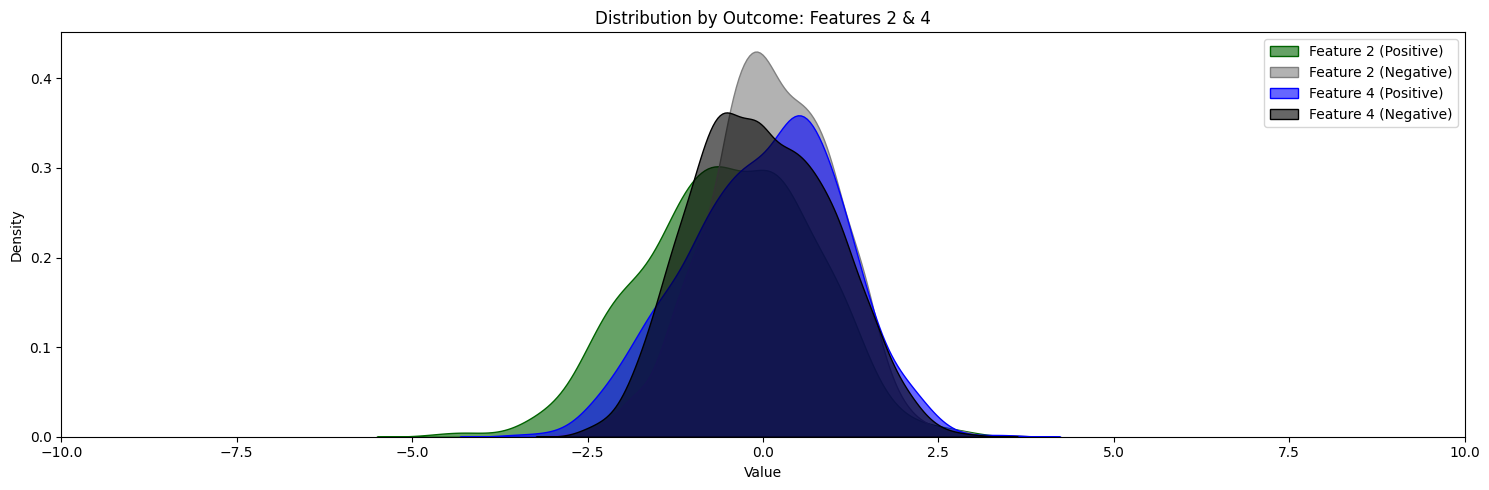

In [356]:
fig, ax = plt.subplots(figsize=(15, 5))

positive_data = train[train['y'] == 1]
negative_data = train[train['y'] == 0]

sns.kdeplot(data=positive_data['feature_2'], ax=ax, fill=True, alpha=0.6, label='Feature 2 (Positive)', color='darkgreen')
sns.kdeplot(data=negative_data['feature_2'], ax=ax, fill=True, alpha=0.6, label='Feature 2 (Negative)', color='grey')
sns.kdeplot(data=positive_data['feature_4'], ax=ax, fill=True, alpha=0.6, label='Feature 4 (Positive)', color='blue')
sns.kdeplot(data=negative_data['feature_4'], ax=ax, fill=True, alpha=0.6, label='Feature 4 (Negative)', color='black')
ax.set_title('Distribution by Outcome: Features 2 & 4')
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.set_xlim(-10, 10)
ax.legend()

plt.tight_layout()
plt.show()


Optimization terminated successfully.
         Current function value: 0.393480
         Iterations 8


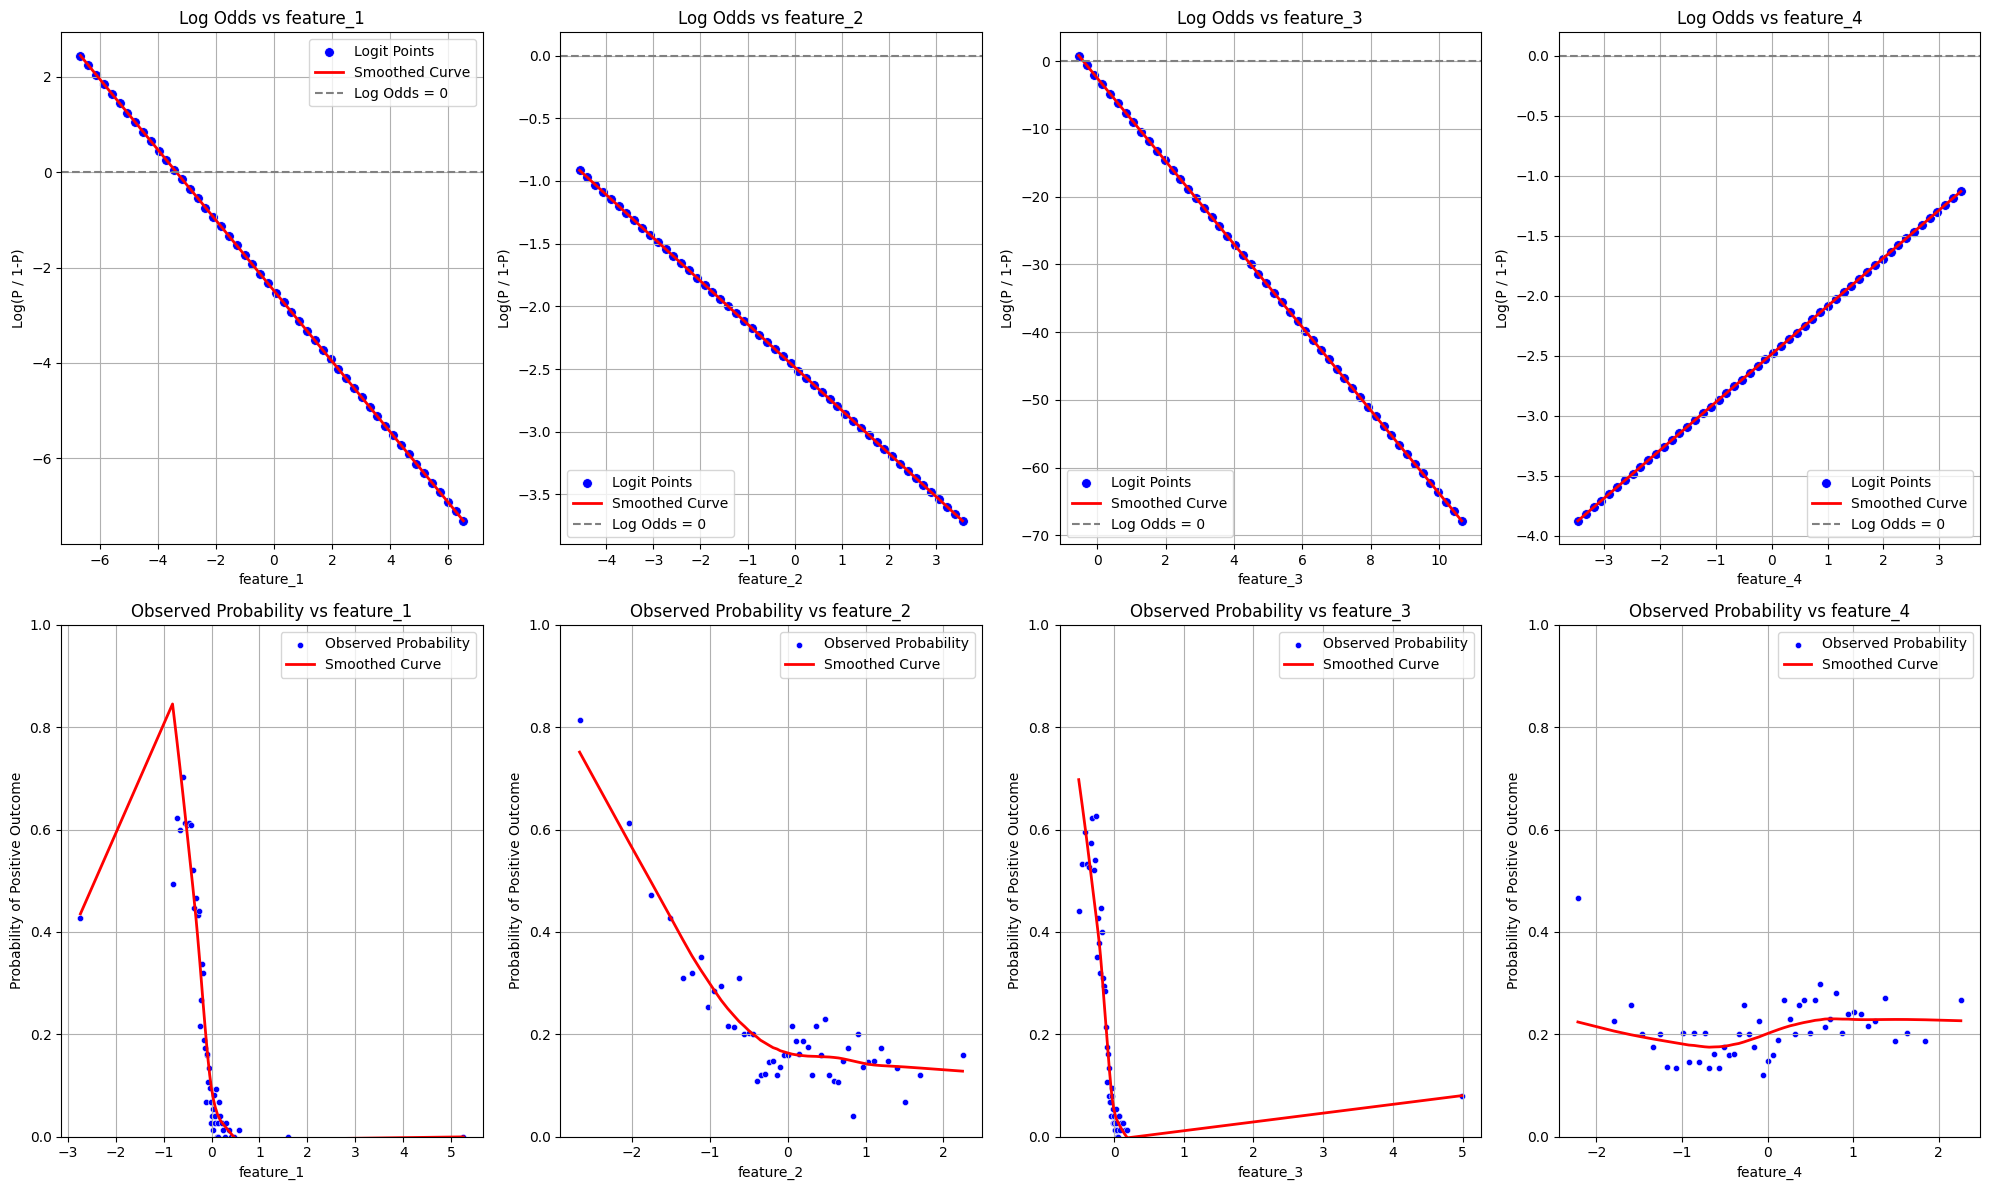

In [357]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.api as sm

X = train[['feature_1', 'feature_2', 'feature_3', 'feature_4']]
y = train['y']

X_with_const = sm.add_constant(X)
logit_model = sm.Logit(y, X_with_const)
result = logit_model.fit()

fig, axes = plt.subplots(2, 4, figsize=(20, 12))

for i, feature in enumerate(['feature_1', 'feature_2', 'feature_3', 'feature_4']):
    feature_values = np.linspace(X[feature].min(), X[feature].max(), 50)
    mean_values = X.mean()
    log_odds = []
    
    for value in feature_values:
        temp_predictors = mean_values.copy()
        temp_predictors[feature] = value
        temp_array = np.array([1, temp_predictors['feature_1'], temp_predictors['feature_2'], 
                             temp_predictors['feature_3'], temp_predictors['feature_4']])
        logit = np.dot(temp_array, result.params)
        log_odds.append(logit)
    
    plot_df = pd.DataFrame({
        feature: feature_values,
        'log_odds': log_odds
    })
    
    sns.scatterplot(x=feature, y='log_odds', data=plot_df, color='blue', s=50, 
                    ax=axes[0,i], label='Logit Points')
    sns.regplot(x=feature, y='log_odds', data=plot_df, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[0,i], label='Smoothed Curve')
    
    axes[0,i].set_title(f'Log Odds vs {feature}')
    axes[0,i].set_xlabel(feature)
    axes[0,i].set_ylabel('Log(P / 1-P)')
    axes[0,i].axhline(0, color='grey', linestyle='--', label='Log Odds = 0')
    axes[0,i].legend()
    axes[0,i].grid(True)
    
    bins = pd.qcut(X[feature], q=50, duplicates='drop')
    bin_means = X.groupby(bins)[feature].mean()
    bin_probs = train.groupby(bins)['y'].mean()
    
    sns.scatterplot(x=bin_means, y=bin_probs, ax=axes[1,i], color='blue', s=20, label='Observed Probability')
    sns.regplot(x=bin_means, y=bin_probs, scatter=False, lowess=True,
                color='red', line_kws={'lw': 2}, ax=axes[1,i], label='Smoothed Curve')
    
    axes[1,i].set_title(f'Observed Probability vs {feature}')
    axes[1,i].set_xlabel(feature)
    axes[1,i].set_ylabel('Probability of Positive Outcome')
    axes[1,i].set_ylim(0, 1)
    axes[1,i].legend()
    axes[1,i].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Setup logistic regression model using GLM method so that we can retrieve residuals
logit_results = GLM(y, X, family=families.Binomial()).fit()

# Setup plot 
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, title="Residual Series Plot",
                     xlabel="Index Number", 
                     ylabel="Deviance Residuals")

# Generate residual series plot using standardized deviance residuals
ax.plot(df_titanic.index.tolist(), 
        stats.zscore(logit_results.resid_deviance))

# Draw horizontal line at y=0
plt.axhline(y = 0, ls="--", color='red')

# Inference: 
# Since the residuals in the plot above appear to be randomly scattered around the centerline 
# of zero, we can infer (visually) that the assumption is satisfied.
# From the above Deviance residuals versus index number plot, 
# we can see that the assumption of independence of errors is satisfied